In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import re
import matplotlib
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import pynocular as pn
import pickle
from scipy import stats
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import pandas

In [42]:
rootdir = '/data/icecube/sim/ic86/retro/'

events = []
n = 0

for subdir, dirs, files in os.walk(rootdir):
    #print subdir
    if len(files) == 0:
        continue
    n+=1    
    
    #if n > 100:
    #    break    
    try:
        #with open(os.path.join(subdir, 'mc_truth.pkl'), 'rb') as f:
        truth_file = np.load(os.path.join(subdir, 'truth.npy'))
        #with open(os.path.join(subdir, 'recos/IC86_Dunkman_L6_MultiNest8D_Track.pkl'), 'rb') as f:
        #    track_file = pickle.load(f)
        #with open(os.path.join(subdir, 'recos/IC86_Dunkman_L6_MultiNest8D_Cascade.pkl'), 'rb') as f:
        #    cascade_file = pickle.load(f)
        #with open(os.path.join(subdir, 'recos/SPEFit2.pkl'), 'rb') as f:
        spefit_file = np.load(os.path.join(subdir, 'recos/SPEFit2.npy'))
    except:
        #print 'skip'
        continue
    
    for event_number in range(len(truth_file)):  
        # --- Truth ---   
        info = {}
        truth = truth_file[event_number]
        try:
            for name in truth_file.dtype.names:
                info[name] = truth[name]
            info['track_azimuth'] = truth['azimuth']
            info['track_zenith'] = np.arccos(truth['coszen'])
            info['track_energy'] = truth['highest_energy_daughter_energy']
            info['neutrino_energy'] = truth['energy']
            info['energy'] = info['track_energy'] + info['cascade_energy'] 

            # --- Pegleg ---
            #event['pegleg_x'] = track_file[event_number]['x']
            #event['pegleg_y'] = track_file[event_number]['y']
            #event['pegleg_z'] = track_file[event_number]['z']
            #event['pegleg_t'] = track_file[event_number]['time']
            #event['pegleg_track_azimuth'] = track_file[event_number]['azimuth']
            #event['pegleg_track_zenith'] = track_file[event_number]['zenith']
            #event['pegleg_track_energy'] = track_file[event_number]['energy']
            #event['pegleg_cascade_energy'] = cascade_file[event_number]['energy']
            #event['pegleg_energy'] = event['pegleg_track_energy'] + event['pegleg_cascade_energy']

            # --- SPEFit ---
            spefit = spefit_file[event_number]
            info['spefit_x'] = spefit['x']
            info['spefit_y'] = spefit['y']
            info['spefit_z'] = spefit['z']
            info['spefit_t'] = spefit['time']
            info['spefit_track_zenith'] = spefit['zenith']
            info['spefit_track_azimuth'] = spefit['azimuth']

            events.append(info)
        except:
            pass

In [43]:
events = pn.PointData(pandas.DataFrame(events))

In [24]:
e_bins = pn.Grid()
e_bins['energy'].edges = np.logspace(0,3,21)

In [11]:
hist = pn.GridData(e_bins)

In [53]:
def angular_dist(theta1, theta2, phi1, phi2):
    '''
    calculate the angular distance between two directions in spherical coords
    '''
    return np.arccos(np.cos(theta1)*np.cos(theta2) + np.sin(theta1)*np.sin(theta2)*np.cos(phi1 - phi2))

x :  (-0.19687812829978152, 14.282171566308806)
y :  (-0.2393645701205161, 15.049528023495354)
z :  (-5.9170661027492546, 12.089399308036718)
t :  (-82.631395081663754, 75.619895703067343)
track_zenith :  (-0.1865018236663129, 0.38127060214034214)
track_azimuth :  (-0.035573242577834119, 0.85947806894106082)


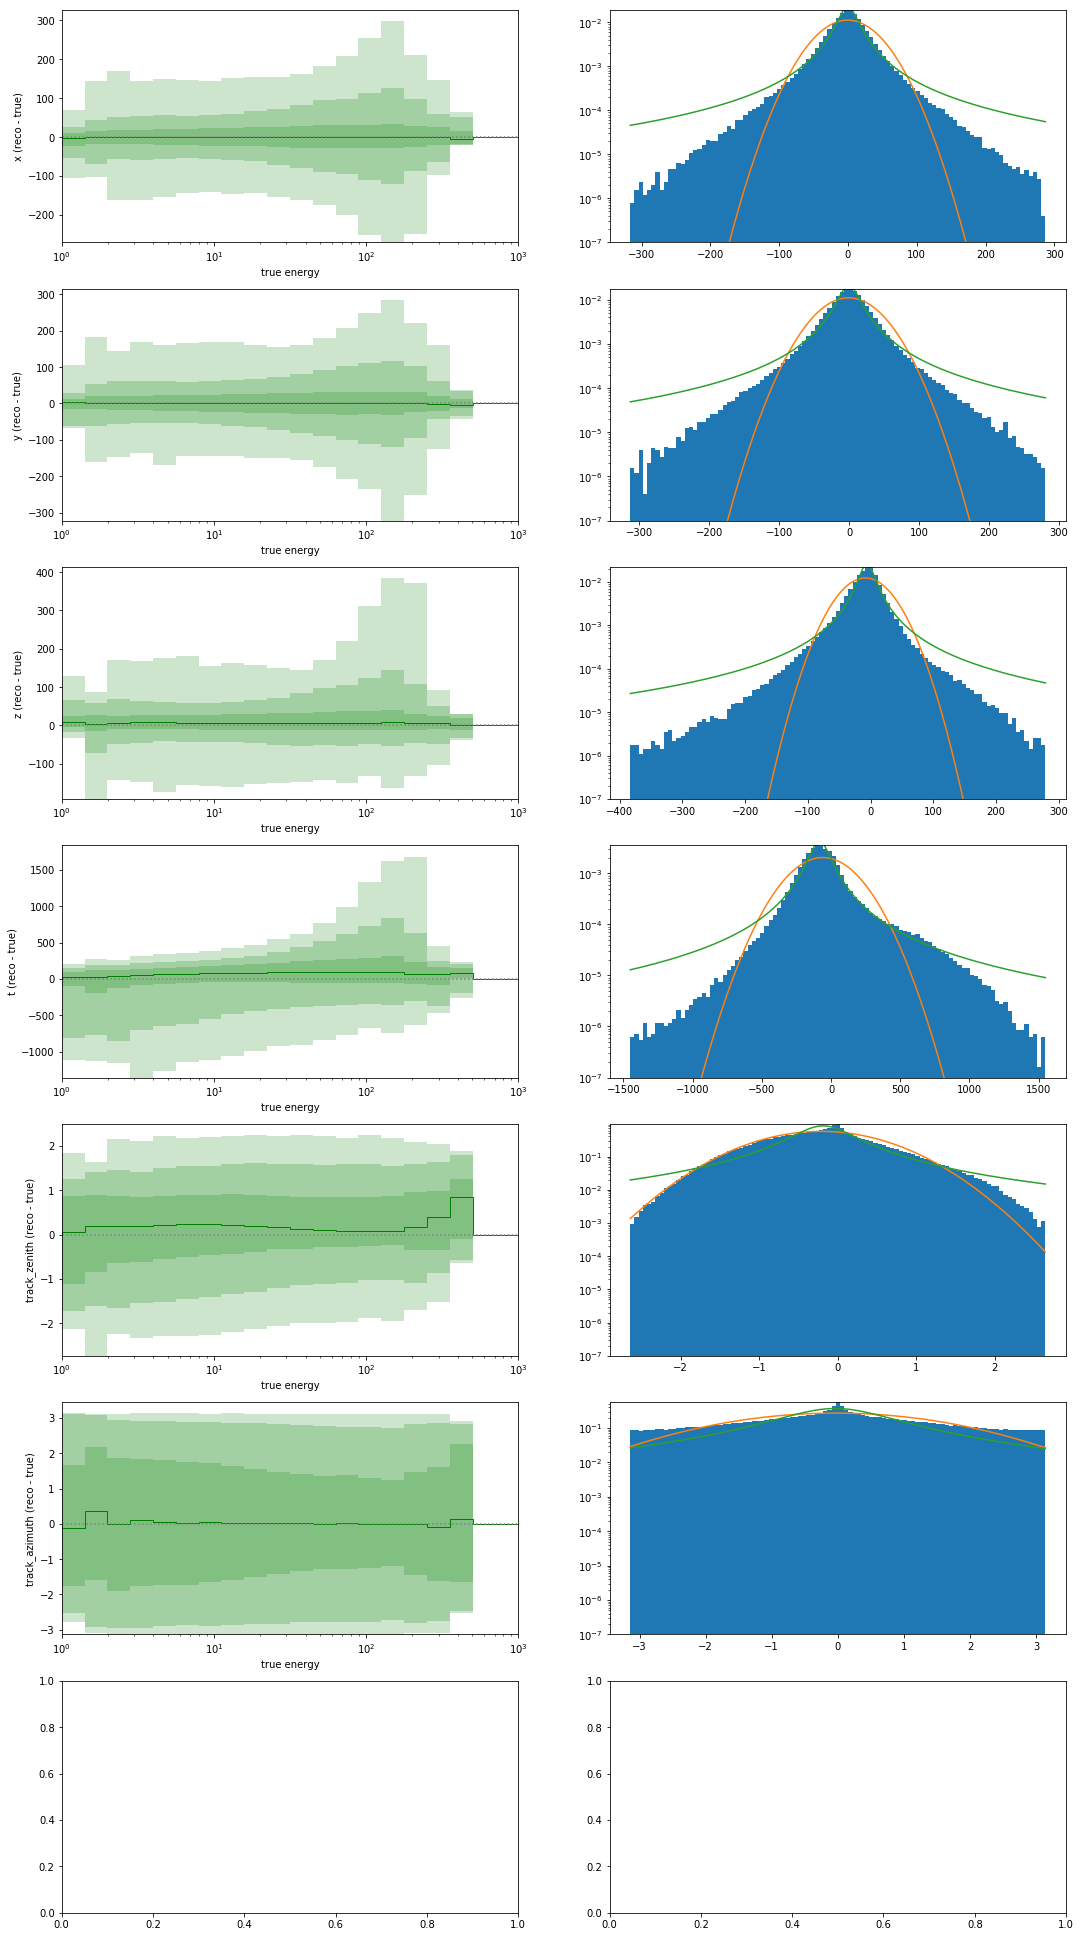

In [55]:
fig, axes = plt.subplots(figsize=(18, 35), ncols=2, nrows=7)
plt.subplots_adjust(hspace = 0.2)

prior_params = {}

def percentile(x, p):
    if len(x) == 0:
        return 0.
    return np.percentile(np.nan_to_num(x), p)

for i, dim in enumerate(['x', 'y', 'z', 't', 'track_zenith', 'track_azimuth']):
    
    ax1 = axes[i,0]
    ax2 = axes[i,1]
    
    true_energy = np.nan_to_num(data['events']['energy'])

    for reco, color in zip(['spefit'], ['green']):
        if not ('energy' in dim and reco == 'spefit'):    
    
            key = reco+'_d_'+dim
            
            if dim == 'angle':
                data['events'][key] = angular_dist(data['events'][reco+'_track_zenith'], data['events']['track_zenith'], data['events'][reco+'_track_azimuth'], data['events']['track_azimuth'])
            else:
                data['events'][key] = data['events'][reco+'_'+dim] - data['events'][dim]

            if 'azimuth' in dim:
                data['events'][key]  = (data['events'][key] + np.pi)%(2*np.pi) - np.pi

            # calculate percentiles
            data.translate(var=key, source='events', dest='e_bins', function=percentile, p=50)
            for s,p in enumerate([68., 95., 99.7]):
                data.translate(var=key, source='events', dest='e_bins', function=percentile, p=(100 - p)/2, dest_var=key+'_lower%is'%(s+1))    
                data.translate(var=key, source='events', dest='e_bins', function=percentile, p=100 - (100 - p)/2, dest_var=key+'_upper%is'%(s+1))     

            # plot
            data['e_bins'].plot_step(fig, ax1, key, histtype='step', color=color)
            for s in ['1s', '2s', '3s']:
                data['e_bins'].plot_band(fig, ax1, key+'_lower'+s, key+'_upper'+s, color=color, alpha=0.2)

                
            # plot resolutions
            d = -np.nan_to_num(data['events'][key])
            h,_,_ = ax2.hist(d, bins=np.linspace(np.percentile(d,0.01),np.percentile(d,99.99),100), normed=True)
            
            # normal dist
            res = stats.norm.fit(d)
            x = np.linspace(np.percentile(d,0.01),np.percentile(d,99.99),1000)
            p = stats.norm.pdf(x, *res)
            ax2.plot(x,p)
            
            # cauchy dist
            res = stats.cauchy.fit(d)
            prior_params[dim] = res
            print '%s : '%dim, res
            p = stats.cauchy.pdf(x, *res)
            ax2.plot(x,p)
            ax2.set_ylim(1e-7, np.max(h))
    
    ax1.set_xlabel('true energy')
    ax1.legend(loc='upper left',ncol=1, frameon=False,numpoints=1,fontsize=10)

    ax1.set_ylabel('%s (reco - true)'%dim)
    ax1.set_xscale('log')
    ax2.set_yscale('log')
    
    ax1.set_xlim(data['e_bins']['energy'][0], data['e_bins']['energy'][-1])
    ax1.plot([0.01,1000],[0,0],ls=':', c='gray')
    
plt.savefig('SPEres.png')

In [30]:
data['e_bins']['spefit_d_t']

array([-204.51962065,   54.30034347,  -25.72751042,   70.29377539,
         62.79877378,   56.72953434,           nan,   63.09304187,
         62.81697722,   62.00900978,   66.84517078,   60.90070818,
         69.78938655,   69.16122003,   38.93379679,   67.04292266,
         63.14128784,   15.95483391,           nan,           nan])

NameError: name 'prior_params' is not defined

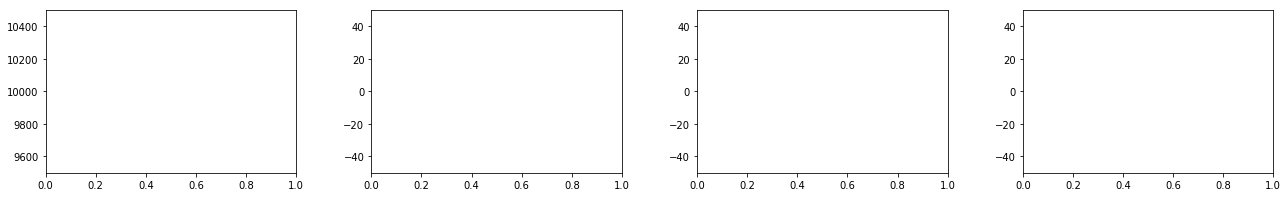

In [3]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(22, 3), ncols=4, nrows=1)
plt.subplots_adjust(wspace = 0.3)

ax1.set_ylim(9500,10500)
ax2.set_ylim(-50,50)
ax3.set_ylim(-50,50)
ax4.set_ylim(-50,50)

print prior_params

q = np.linspace(0,1,1000)
spe_fit = {'t':10000, 'x':0, 'y':0, 'z':0}

for ax,dim in zip([ax1, ax2, ax3, ax4], ['t', 'x', 'y', 'z']):
    ax.plot(q,stats.cauchy.isf(q, loc=spe_fit[dim]+prior_params[dim][0], scale=prior_params[dim][1]))
    ax.set_ylabel(dim)
    ax.set_xlabel('cube')

In [100]:
cube = np.random.rand(10000)

In [101]:
coszen = 2 * cube -1

In [102]:
zen = np.arccos(coszen)

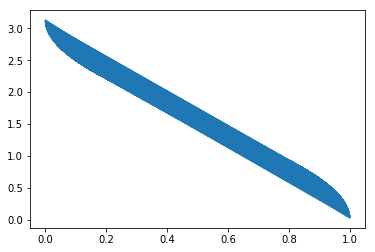

In [103]:
plt.plot(cube, zen)

In [105]:
weights = 1./np.clip(np.sin(zen), 0.01, None)

(array([ 1509.30288781,  1532.87200868,  1563.21243292,  1566.55719726,
         1540.83138208,  1575.05351654,  1540.76637581,  1565.87286305,
         1513.46143224,  1605.33848188]),
 array([ 0.02783781,  0.3376086 ,  0.64737938,  0.95715017,  1.26692095,
         1.57669174,  1.88646252,  2.19623331,  2.50600409,  2.81577488,
         3.12554567]),
 <a list of 10 Patch objects>)

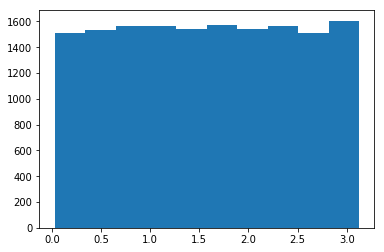

In [106]:
plt.hist(zen, weights=weights)

In [44]:
len(events.data)

659908

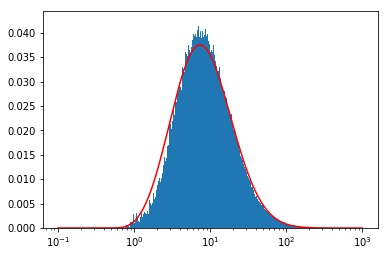

In [52]:
plt.hist(np.nan_to_num(events['energy']), bins=np.logspace(-1,3,1000), normed=True)
fit = stats.lognorm.fit(events['energy'][np.isfinite(events['energy'])])
x = np.logspace(-1,3,1000)
p = stats.lognorm.pdf(x, *fit)
plt.plot(x,p, color='r')
plt.gca().set_xscale('log')
#plt.gca().set_yscale('log')
plt.savefig('energy_prior.png')

In [53]:
print fit

(0.96251341305506233, 0.4175592980195757, 17.543915051586644)


In [64]:
for dim in ['x', 'y', 'z', 'time', 'energy']:
    print '%s : (%s, %s)'%(dim, np.nanmin(events[dim]), np.nanmax(events[dim]))

x : (-512.48794273, 648.672909515)
y : (-671.006133914, 568.576223788)
z : (-1115.07048038, 111.720839975)
time : (7137.50228754, 20362.3733507)
energy : (0.421088472494, 1667.24891475)
